# Corrected Diabetes Modeling Notebook

This notebook is a cleaned and corrected version of the uploaded notebook. Main fixes applied:

- Missing imports added
- Scaling and preprocessing occur _after_ train/test split using `ColumnTransformer` + `Pipeline` (no data leakage)
- `stratify` used in train/test split
- Avoided SMOTE on one-hot encoded features; used `class_weight='balanced'` for classifiers (alternative SMOTENC commented)
- Correct ROC AUC computation using probabilities
- Saved the full pipeline (preprocessing + model) for inference
- Fixed undefined variables like `numeric_features`

You can run the cells top-to-bottom. Adjust hyperparameter grids as needed.

In [1]:

# Imports and settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, confusion_matrix, classification_report)

import joblib
import warnings
warnings.filterwarnings('ignore')

# display settings
%matplotlib inline


In [2]:

# Load data (adjust path if needed)
df = pd.read_csv('data/diabetes_prediction_dataset.csv')
print('Original shape:', df.shape)
df.head()


Original shape: (100000, 9)


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [3]:

# Basic cleaning / feature engineering (non-leaky)
# Remove 'Other' gender and map to numeric
df = df[df['gender'] != 'Other'].copy()
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

# Replace 'No Info' with 'unknown' in smoking_history
df['smoking_history'] = df['smoking_history'].replace('No Info', 'unknown')

# Keep raw copies (for reference only) but do not use raw columns directly in model pipeline below
df['age_raw'] = df['age']
df['bmi_raw'] = df['bmi']
df['glucose_raw'] = df['blood_glucose_level']
df['HbA1c_raw'] = df['HbA1c_level']

# Derived features (these are okay -- they are deterministic transformations of existing features)
df['bmi_per_age'] = df['bmi_raw'] / (df['age_raw'].replace(0, np.nan))
df['glucose_HbA1c_ratio'] = df['glucose_raw'] / (df['HbA1c_raw'].replace(0, np.nan))
df['is_elderly'] = (df['age_raw'] > 60).astype(int)
df['is_obese'] = (df['bmi_raw'] >= 30).astype(int)

# Fill any infinite / NaN results from divisions
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

print('After basic cleaning:', df.shape)
df.head()


After basic cleaning: (99982, 17)


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,age_raw,bmi_raw,glucose_raw,HbA1c_raw,bmi_per_age,glucose_HbA1c_ratio,is_elderly,is_obese
0,0,80.0,0,1,never,25.19,6.6,140,0,80.0,25.19,140,6.6,0.314875,21.212121,1,0
1,0,54.0,0,0,unknown,27.32,6.6,80,0,54.0,27.32,80,6.6,0.505926,12.121212,0,0
2,1,28.0,0,0,never,27.32,5.7,158,0,28.0,27.32,158,5.7,0.975714,27.719298,0,0
3,0,36.0,0,0,current,23.45,5.0,155,0,36.0,23.45,155,5.0,0.651389,31.000000,0,0
4,1,76.0,1,1,current,20.14,4.8,155,0,76.0,20.14,155,4.8,0.265000,32.291667,1,0


In [4]:

# Define feature lists
numeric_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'bmi_per_age', 'glucose_HbA1c_ratio']
categorical_features = ['smoking_history', 'gender', 'hypertension', 'heart_disease', 'is_elderly', 'is_obese']

# Keep X and y
X = df[numeric_features + categorical_features].copy()
y = df['diabetes'].astype(int).values

# Stratified split to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11, stratify=y)

print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)


Train shape: (79985, 12) Test shape: (19997, 12)


In [6]:

# Preprocessing: scale numeric, one-hot encode categorical
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
])

# Build pipeline with classifier. Use class_weight to handle imbalance (avoids SMOTE pitfalls)
pipe = Pipeline([
    ('preproc', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced', random_state=42))
])

# Fit pipeline on training data
pipe.fit(X_train, y_train)

# Predict probabilities and labels on test set
y_proba = pipe.predict_proba(X_test)[:, 1]
y_pred = (y_proba > 0.5).astype(int)

# Correct metrics
print('Classification report:')
print(classification_report(y_test, y_pred))
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_proba))


Classification report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.93     18297
           1       0.41      0.87      0.56      1700

    accuracy                           0.88     19997
   macro avg       0.70      0.88      0.75     19997
weighted avg       0.94      0.88      0.90     19997

Confusion matrix:
 [[16201  2096]
 [  219  1481]]
ROC AUC: 0.959820221251314


Accuracy: 0.8842326348952343
Precision: 0.4140341067934023
Recall: 0.8711764705882353
F1: 0.5613037710820542
ROC AUC: 0.959820221251314


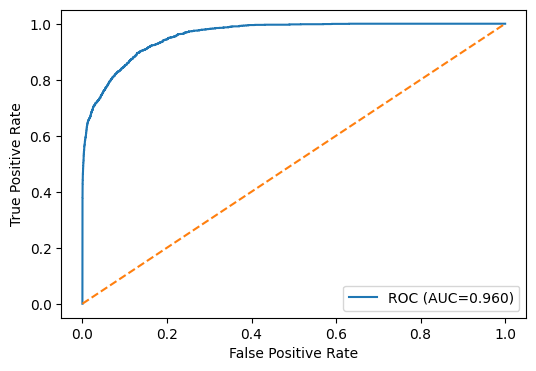

In [7]:

def print_metrics(y_true, y_pred, y_proba=None):
    print('Accuracy:', accuracy_score(y_true, y_pred))
    print('Precision:', precision_score(y_true, y_pred, zero_division=0))
    print('Recall:', recall_score(y_true, y_pred, zero_division=0))
    print('F1:', f1_score(y_true, y_pred, zero_division=0))
    if y_proba is not None:
        print('ROC AUC:', roc_auc_score(y_true, y_proba))
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        plt.figure(figsize=(6,4))
        plt.plot(fpr, tpr, label=f'ROC (AUC={roc_auc_score(y_true, y_proba):.3f})')
        plt.plot([0,1],[0,1],'--')
        plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.legend();
        plt.show()

print_metrics(y_test, y_pred, y_proba)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best params: {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Accuracy: 0.8851327699154873
Precision: 0.4161752316764954
Recall: 0.8717647058823529
F1: 0.5633909903060255
ROC AUC: 0.9597783950438677


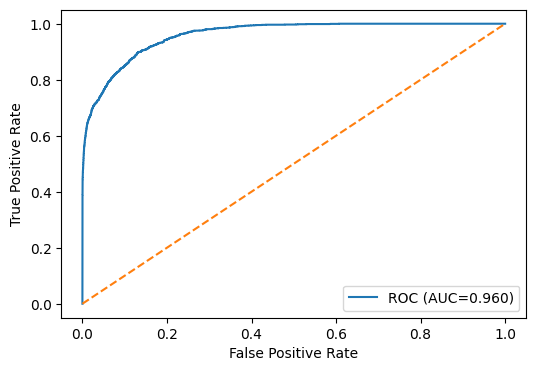

In [8]:

# Example grid search (use small grid to save time)
param_grid = {
    'clf__C': [0.01, 0.1, 1],
    'clf__penalty': ['l1', 'l2'],
    'clf__solver': ['liblinear']
}

grid = GridSearchCV(pipe, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print('Best params:', grid.best_params_)
best_pipe = grid.best_estimator_

# Evaluate best pipeline
y_proba_gs = best_pipe.predict_proba(X_test)[:,1]
y_pred_gs = (y_proba_gs > 0.5).astype(int)
print_metrics(y_test, y_pred_gs, y_proba_gs)



Random Forest metrics:
Accuracy: 0.9686953042956443
Precision: 0.9416118421052632
Recall: 0.6735294117647059
F1: 0.7853223593964335
ROC AUC: 0.9659950843757735


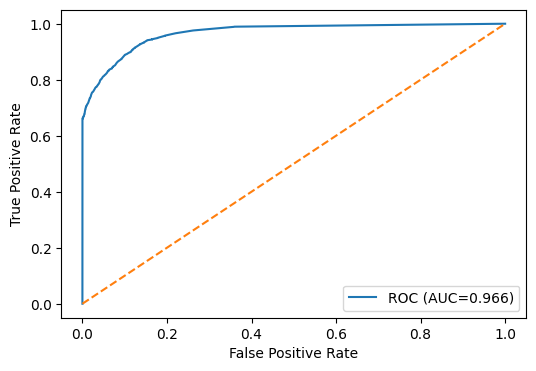


Gradient Boosting metrics:
Accuracy: 0.9713457018552782
Precision: 0.9828620394173093
Recall: 0.6747058823529412
F1: 0.8001395186606208
ROC AUC: 0.9781795954978155


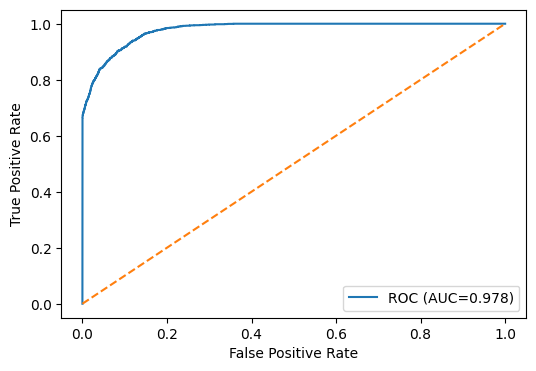

In [9]:

# Train RandomForest and GradientBoosting as examples
rf_pipe = Pipeline([
    ('preproc', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42))
])
rf_pipe.fit(X_train, y_train)
y_proba_rf = rf_pipe.predict_proba(X_test)[:,1]
y_pred_rf = (y_proba_rf > 0.5).astype(int)
print('\nRandom Forest metrics:')
print_metrics(y_test, y_pred_rf, y_proba_rf)

gb_pipe = Pipeline([
    ('preproc', preprocessor),
    ('clf', GradientBoostingClassifier(n_estimators=200, random_state=42))
])
gb_pipe.fit(X_train, y_train)
y_proba_gb = gb_pipe.predict_proba(X_test)[:,1]
y_pred_gb = (y_proba_gb > 0.5).astype(int)
print('\nGradient Boosting metrics:')
print_metrics(y_test, y_pred_gb, y_proba_gb)


In [10]:

# Save the best pipeline (grid search best or the original pipeline)
pipeline_to_save = grid.best_estimator_ if 'grid' in globals() else pipe
joblib.dump(pipeline_to_save, 'diabetes_pipeline.joblib')
print('Saved pipeline to diabetes_pipeline.joblib')


Saved pipeline to diabetes_pipeline.joblib


In [11]:

# Example: load pipeline and predict on a single raw sample (values are raw, not scaled)
loaded = joblib.load('diabetes_pipeline.joblib')

sample = X_test.iloc[0:1]
print('Sample raw values:\n', sample.to_dict(orient='records'))
print('Pred proba:', loaded.predict_proba(sample)[:,1])
print('Pred label:', loaded.predict(sample))


Sample raw values:
 [{'age': 80.0, 'bmi': 28.03, 'HbA1c_level': 5.7, 'blood_glucose_level': 100, 'bmi_per_age': 0.350375, 'glucose_HbA1c_ratio': 17.543859649122805, 'smoking_history': 'never', 'gender': 0, 'hypertension': 0, 'heart_disease': 0, 'is_elderly': 1, 'is_obese': 0}]
Pred proba: [0.15546477]
Pred label: [0]


In [ ]:
# Define your top 3 models (make sure these variables exist in your environment)
top_models = {
    'Gradient Boosting Balanced Weights': gb_balanced,
    'Gradient Boosting + SMOTE': gb,  # Your original SMOTE model from cell 116
    'Random Forest Balanced Weights': rf_balanced
}

# Analysis results dictionary
detailed_results = {}

print("=== DETAILED ANALYSIS OF TOP 3 MODELS ===\n")

for name, model in top_models.items():
    print(f"\n--- Analyzing {name} ---")
    
    # Get predictions
    y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
    y_pred = model.predict(X_test_processed)
    
    # PR AUC Analysis
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    
    # Cost analysis (medical context: FN cost >> FP cost)
    cost = calculate_cost(y_test, y_pred, cost_fp=1, cost_fn=10)
    
    # Medical metrics
    med_metrics = medical_metrics(y_test, y_pred)
    
    # Optimal threshold (optional)
    optimal_threshold, optimal_f1 = find_optimal_threshold(model, X_test_processed, y_test)
    
    # Store results
    detailed_results[name] = {
        'pr_auc': pr_auc,
        'avg_precision': avg_precision,
        'total_cost': cost,
        'medical_metrics': med_metrics,
        'optimal_threshold': optimal_threshold,
        'optimal_f1': optimal_f1
    }
    
    # Print summary
    print(f"PR AUC: {pr_auc:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Total Cost (FP=1, FN=10): {cost}")
    print(f"Sensitivity: {med_metrics['Sensitivity (Recall)']:.4f}")
    print(f"Specificity: {med_metrics['Specificity']:.4f}")
    print(f"Optimal Threshold: {optimal_threshold:.3f} (F1: {optimal_f1:.4f})")

# Comparative analysis
print("\n" + "="*50)
print("COMPARATIVE ANALYSIS")
print("="*50)

for metric in ['pr_auc', 'avg_precision', 'total_cost']:
    print(f"\nBest {metric}:")
    best_model = min(detailed_results.items(), key=lambda x: x[1][metric]) if metric == 'total_cost' else max(detailed_results.items(), key=lambda x: x[1][metric])
    print(f"  {best_model[0]}: {best_model[1][metric]:.4f}")

In [ ]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score, confusion_matrix
import numpy as np

# Define the helper functions first
def calculate_cost(y_true, y_pred, cost_fp=1, cost_fn=10):
    """Calculate total cost of misclassifications"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    total_cost = fp * cost_fp + fn * cost_fn
    return total_cost

def medical_metrics(y_true, y_pred):
    """Calculate medical diagnostic metrics"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    metrics = {
        'Sensitivity (Recall)': tp / (tp + fn),
        'Specificity': tn / (tn + fp),
        'False Positive Rate': fp / (fp + tn),
        'False Negative Rate': fn / (fn + tp),
        'Positive Predictive Value (Precision)': tp / (tp + fp),
        'Negative Predictive Value': tn / (tn + fn),
        'False Omission Rate': fn / (fn + tn)  # Important for medical screening
    }
    return metrics

def find_optimal_threshold(model, X_test, y_test):
    """Find optimal classification threshold"""
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    thresholds = np.arange(0.1, 0.9, 0.05)
    best_threshold = 0.5
    best_f1 = 0
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        f1 = f1_score(y_test, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    return best_threshold, best_f1

In [ ]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

# Calculate PR AUC for your best models
y_pred_proba = best_gb_model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)
average_precision = average_precision_score(y_test, y_pred_proba)

In [13]:
import pickle
with open('model.bin', 'rb') as f_in:
    pipeline = pickle.load(f_in)

AttributeError: Can't get attribute 'preprocess' on <module '__main__'>